## Help NGO


In [1]:
# Importing Depedencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings 
warnings.filterwarnings('ignore')



In [2]:
# Reading the dataset

df = pd.read_csv('country-data.csv')

In [3]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# Total number of rows and columns
df.shape

(167, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


### Cleaning the data


In the given data above column exports, health and imports are given in % so, we need to convert them back to normal values

In [6]:
df['exports']=(df['exports']*df['gdpp'])/100
df['health']=(df['health']*df['gdpp'])/100
df['imports']=(df['imports']*df['gdpp'])/100

In [7]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### EDA Analysis

In [8]:
# Performinf univariate analysis on the given data an finding out some insights

f = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

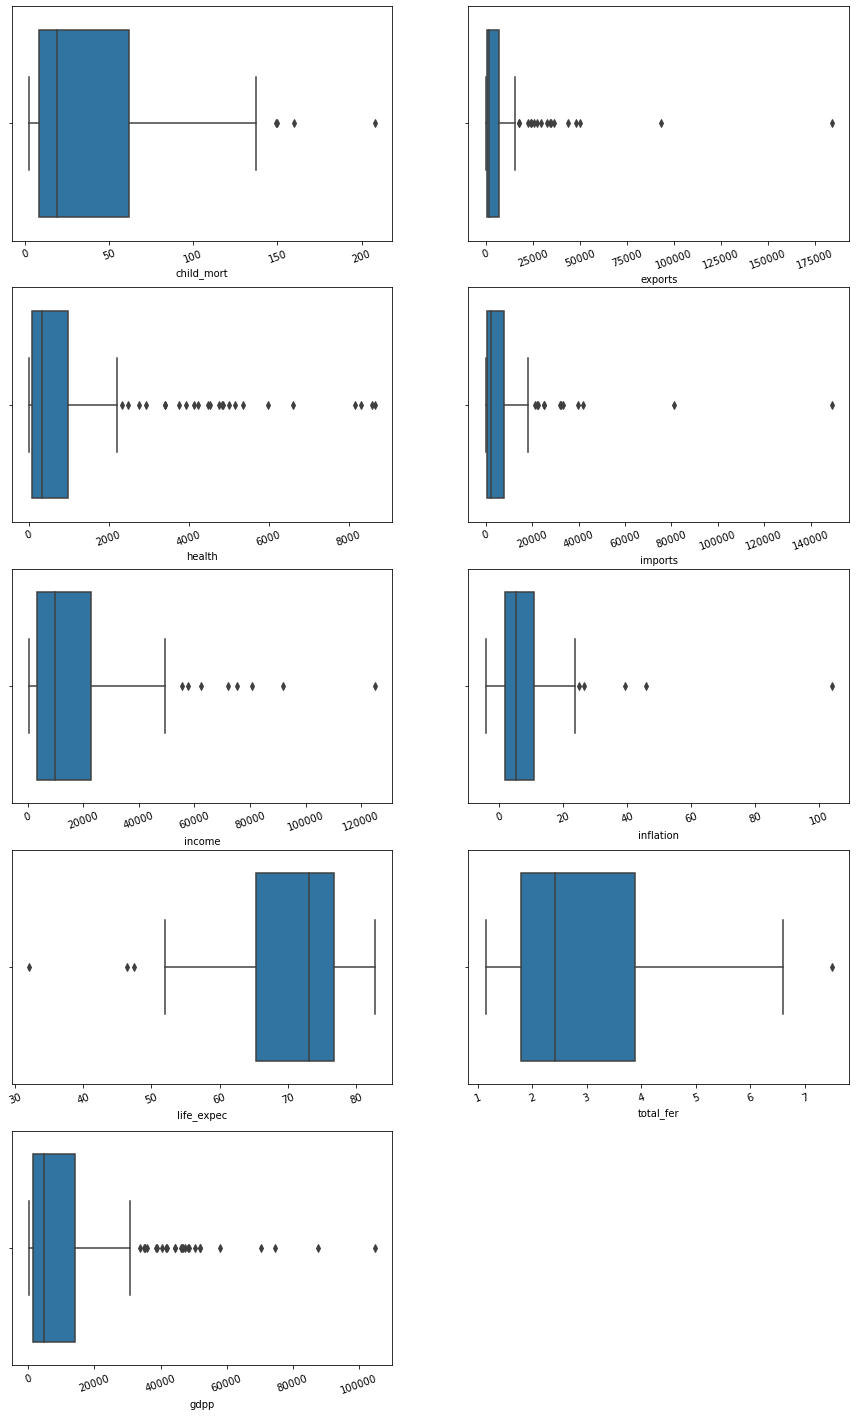

In [9]:
plt.figure(figsize=(15,25))
for i in enumerate(f):
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation = 20)
plt.show()    


These box plots clearly shows outliers in the columns.

- Here we are not treating the outliers. Dropping or capping the outliers can manipulate our results as we need to identify those countries which are in dire need of help.

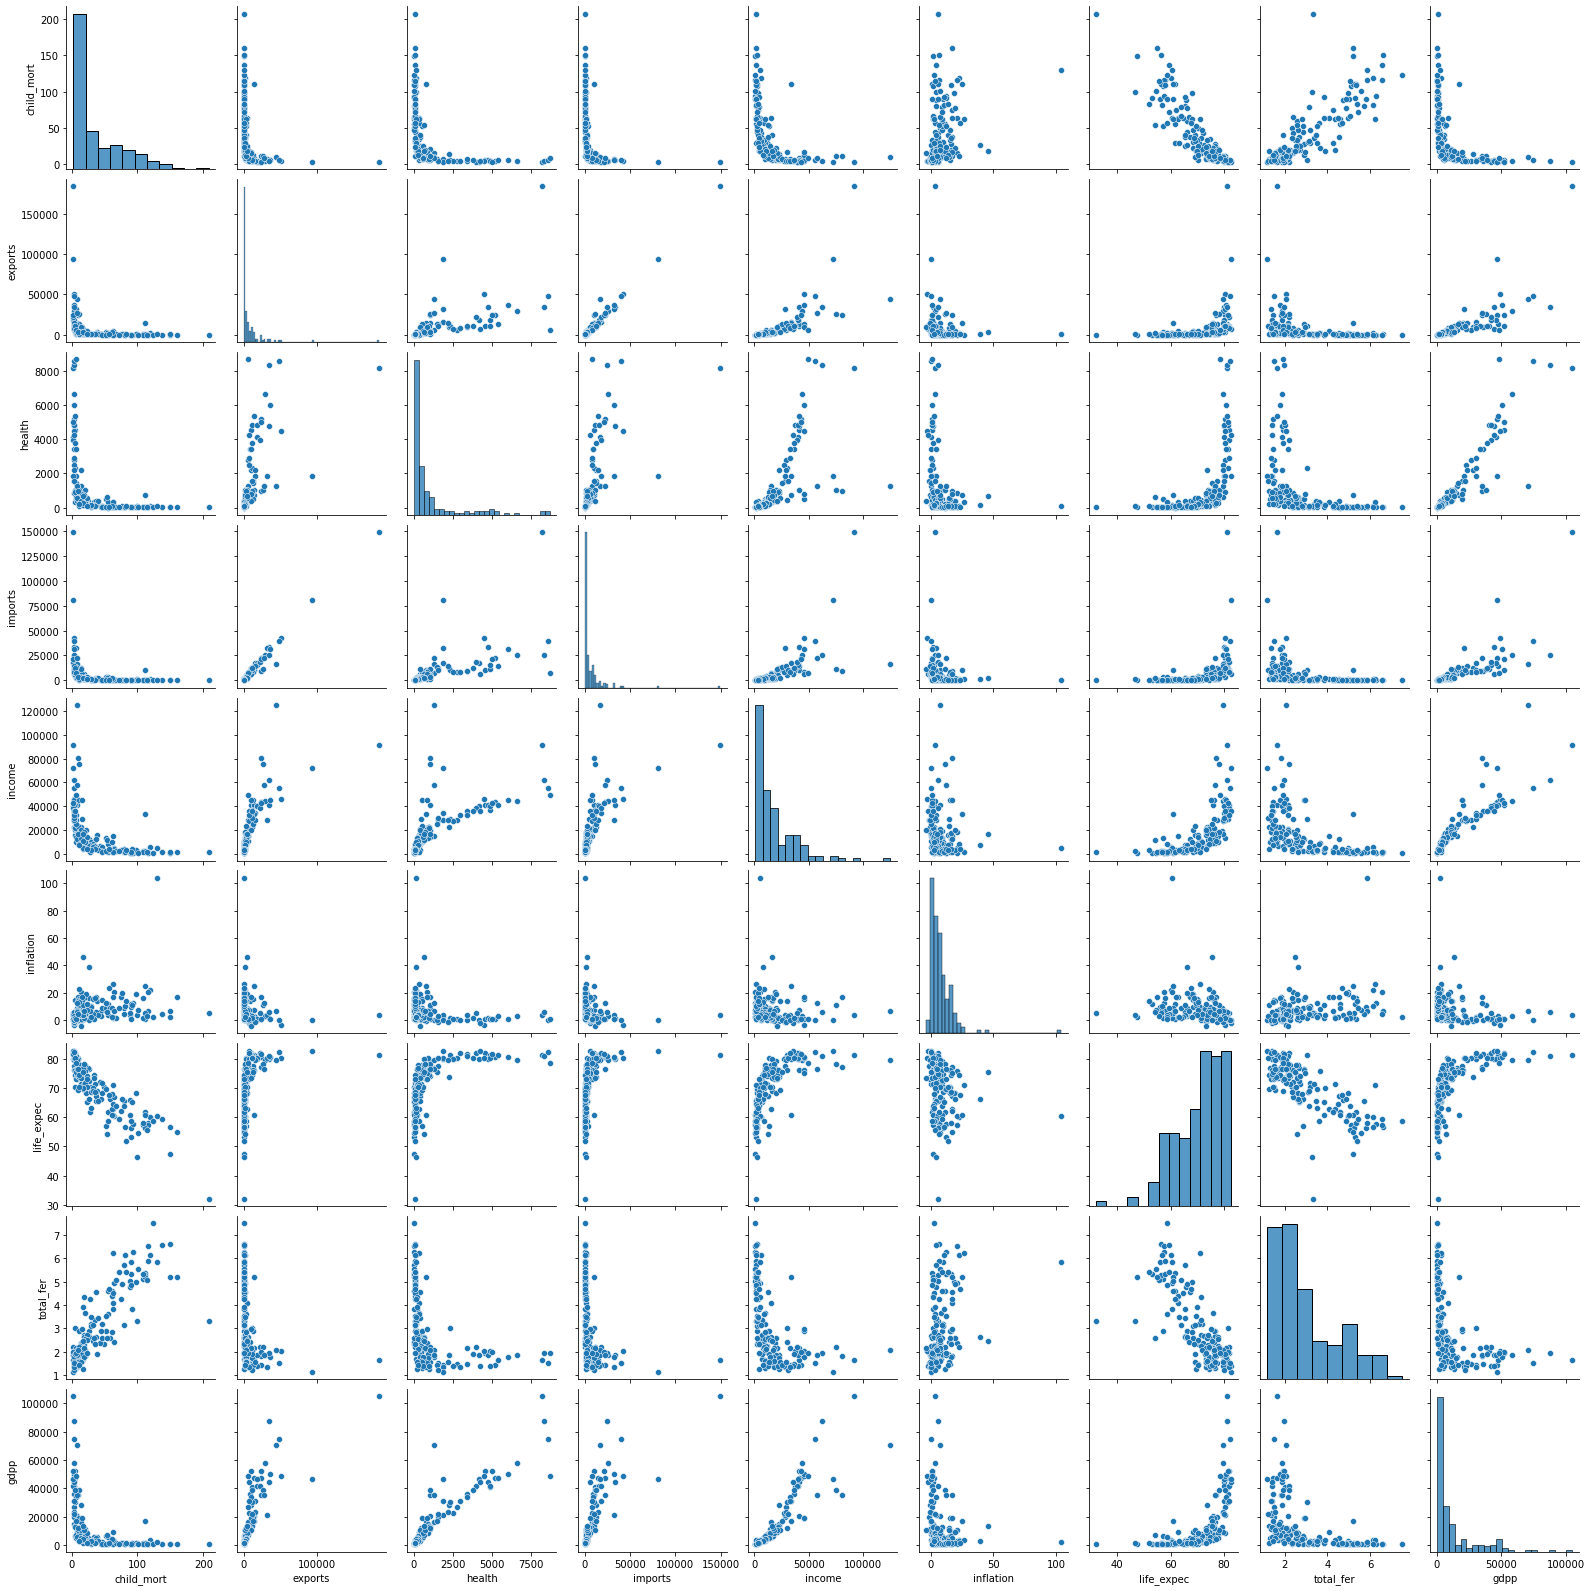

In [10]:
# performing mulitivariate analysis and getting some insights of the correlation of the data.

sns.pairplot(df)
plt.show()

In [11]:
df.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.297230,-0.430438,-0.319138,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.297230,1.000000,0.612919,0.987686,0.725351,-0.141553,0.377694,-0.291096,0.768894
health,-0.430438,0.612919,1.000000,0.638581,0.690857,-0.253956,0.545626,-0.407984,0.916593
imports,-0.319138,0.987686,0.638581,1.000000,0.672056,-0.179458,0.397515,-0.317061,0.755114
income,-0.524315,0.725351,0.690857,0.672056,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.141553,-0.253956,-0.179458,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.377694,0.545626,0.397515,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.291096,-0.407984,-0.317061,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.768894,0.916593,0.755114,0.895571,-0.221631,0.600089,-0.454910,1.000000


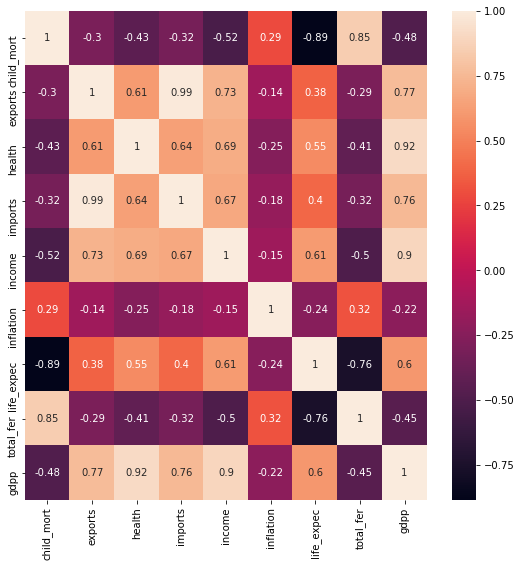

In [12]:
plt.figure(figsize=(9,9))
sns.heatmap(df.corr(),annot=True)
plt.show()

- Here we can see a very high correlation between the columns but we can work which these correlations as clustering is not affected much by the correlations betweeen variables.

### Preprocessing


Hokins test

In [13]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

In [14]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [15]:
hopkins(df.drop('country',axis=1))

0.9747398548906175

- The data looks good for the clustering

### Scaling the data for clustering

In [16]:
# Here we are using standard scalar

df1 = df.drop('country',axis=1)

In [17]:
SS = StandardScaler()
df1 = SS.fit_transform(df1)

### KMeans Clustering

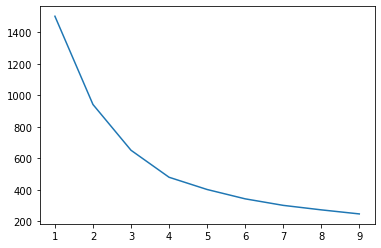

In [18]:
# Finding optimal number of clusters

# Elbow Curve 


ssd = []
for k in list(range(1,10)):
    model = KMeans(n_clusters = k, max_iter = 50).fit(df1)
    ssd.append([k, model.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1]);

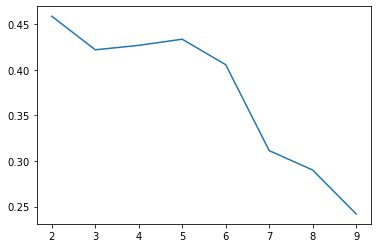

In [19]:
ss = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k).fit(df1)
    ss.append([k , silhouette_score(df1,kmeans.labels_)])
    
plt.plot(pd.DataFrame(ss)[0],pd.DataFrame(ss)[1])

- since we are getting very strange results we will be using silhoutte score to determine the optimal number of k.

In [20]:
range_n_clusters = [2,3,4,5,6,7,8]

for num_clusters in range_n_clusters:
    
    
    # intialise kmeans 
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(df1)
    
    clsuters_labels = kmeans.labels_
    
    
    # Silhoutte score 
    silhoutte_avg = silhouette_score(df1 , clsuters_labels)
    print('For n_clusters = {0}, the silhoutte score is {1}'.format(num_clusters ,silhoutte_avg ))

For n_clusters = 2, the silhoutte score is 0.45863306035476264
For n_clusters = 3, the silhoutte score is 0.4218615812599681
For n_clusters = 4, the silhoutte score is 0.42914711278370843
For n_clusters = 5, the silhoutte score is 0.43077513396770467
For n_clusters = 6, the silhoutte score is 0.4036284811044092
For n_clusters = 7, the silhoutte score is 0.31136565295133073
For n_clusters = 8, the silhoutte score is 0.2983830021707988


- Optimal number of k is 5 # According to the silhoutte score

### Initialising kmeans

In [21]:
kmeans = KMeans(n_clusters = 5 , max_iter=100,random_state=100)
kmeans.fit(df1)

KMeans(max_iter=100, n_clusters=5, random_state=100)

In [22]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 4, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 3, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [23]:
# Keeping the oroginal data safe 

df_org = df.copy()

In [24]:
df_km = pd.concat([df , pd.Series(kmeans.labels_)] , axis =1 )
df_km.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','cluster_id']
df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1


In [25]:
df_km['cluster_id'].value_counts()

1    88
0    47
2    30
3     1
4     1
Name: cluster_id, dtype: int64

### Visualizing the clusters

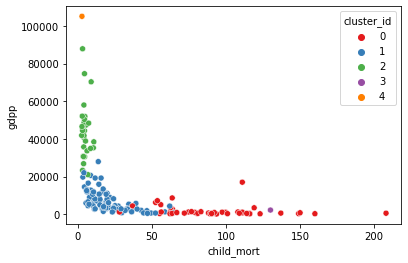

In [26]:
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

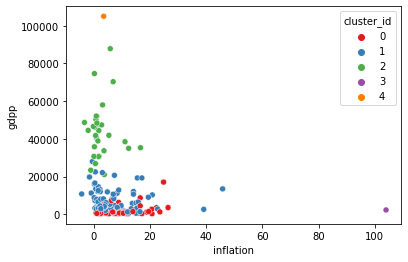

In [27]:
sns.scatterplot(x = 'inflation', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

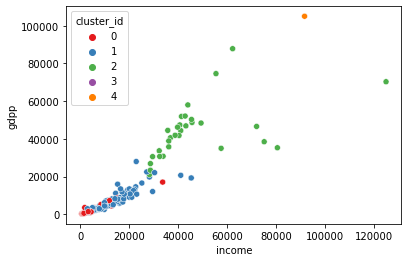

In [28]:
sns.scatterplot(x = 'income', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

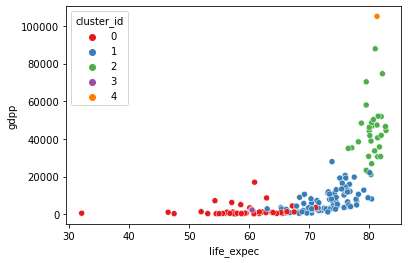

In [29]:
sns.scatterplot(x = 'life_expec', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

 since we are getting 2 useless clusters we will go for the value K=3.

In [30]:
kmeans = KMeans(n_clusters=3, max_iter=100 , random_state = 100)
kmeans.fit(df1)

KMeans(max_iter=100, n_clusters=3, random_state=100)

In [31]:
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 2, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 0, 2, 2, 1, 1, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [32]:
df_org1 = df.copy()

In [33]:
df_km1 = pd.concat([df, pd.Series(kmeans.labels_)], axis = 1)
df_km1.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','cluster_id']
df_km1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,2


In [34]:
df_km1['cluster_id'].value_counts()

2    91
1    48
0    28
Name: cluster_id, dtype: int64

- This looks fine.

### KMeans cluster visualization

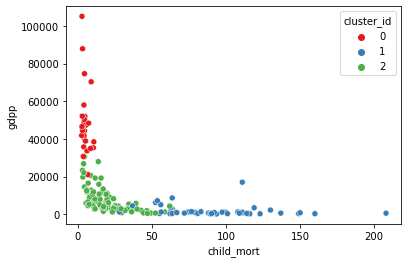

In [35]:
# visualizating the cluster using scatter plot for variables like child_mort, inflation, income, life_exp.
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km1, palette='Set1')
plt.show()

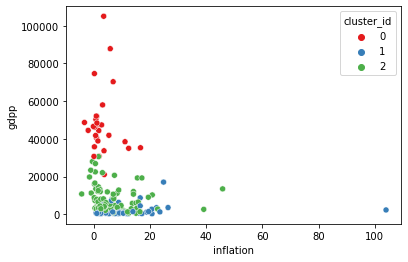

In [36]:
sns.scatterplot(x = 'inflation', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km1, palette='Set1')
plt.show()

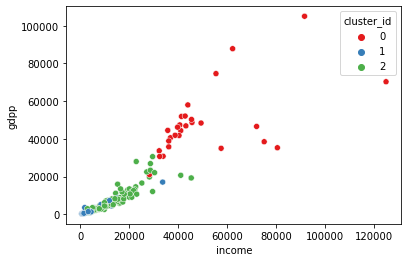

In [37]:
sns.scatterplot(x = 'income', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km1, palette='Set1')
plt.show()

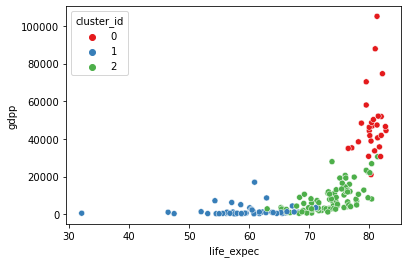

In [38]:
sns.scatterplot(x = 'life_expec', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km1, palette='Set1')
plt.show()

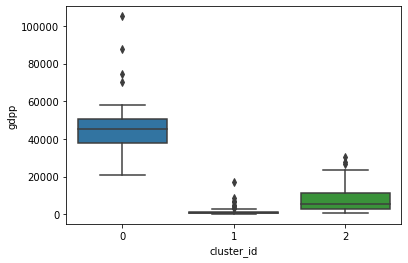

In [39]:
# Here we will be profiling for these 3 variables as mentioned in problem statement (gdpp, child_mort and income).
sns.boxplot(data=df_km1,x = 'cluster_id',y='gdpp')
plt.show()

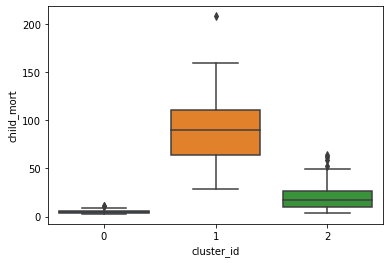

In [40]:
sns.boxplot(data=df_km1,x = 'cluster_id',y='child_mort')
plt.show()

In [41]:
#Finding the observations that belong to cluster id 0
df_km1[df_km1['cluster_id']==1]['country']

0                   Afghanistan
3                        Angola
17                        Benin
21                     Botswana
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106     

In [42]:
top_kmeans = df_km1[df_km1['cluster_id']==1].sort_values(by=["child_mort","gdpp","income"], ascending=[False, True,True])
top_kmeans = top_kmeans.reset_index().drop('index',axis=1)
top_kmeans.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,1
1,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,1
2,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,1
3,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,1
4,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,1
5,Nigeria,130.0,589.490,118.1310,405.420,5150,104.00,60.5,5.84,2330,1
6,Niger,123.0,77.256,17.9568,170.868,814,2.55,58.8,7.49,348,1
7,Angola,119.0,2199.190,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1
8,"Congo, Dem. Rep.",116.0,137.274,26.4194,165.664,609,20.80,57.5,6.54,334,1
9,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.81,57.9,5.87,575,1


In [43]:
top_10 = top_kmeans.iloc[:10]
top_10['country'].reset_index().drop('index',axis=1)

,country
0,Haiti
1,Sierra Leone
2,Chad
3,Central African Republic
4,Mali
5,Nigeria
6,Niger
7,Angola
8,"Congo, Dem. Rep."
9,Burkina Faso


 - Top 10 counties using kMeans clustering.
 
 These are the top 10 countries we will be focusing on for providing the adequate help.

### Heirarichal Clustering

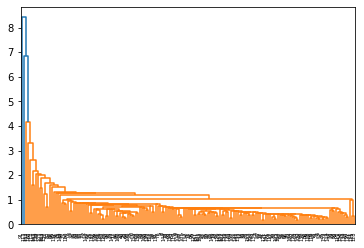

In [44]:
# Forming clusters with the help of Heirarichal Clustering using single linkage.
mergings_single = linkage(df1, method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()

- clusters are not forming using single linkage so we will be using complete linkage for further processing.

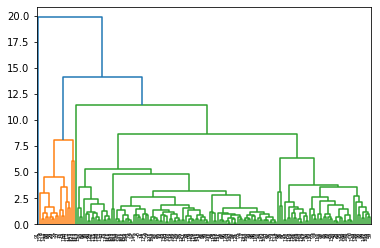

In [45]:
mergings_complete = linkage(df1, method="complete", metric='euclidean')
dendrogram(mergings_complete)
plt.show()

- looking at this we can say that there are 3 clusters forming with heirarichal clustering.¶

In [46]:
cluster_labels = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [47]:
df_hm = pd.concat([df, pd.Series(cluster_labels)], axis = 1)
df_hm.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','cluster_labels']
df_hm.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


In [48]:
df_hm['cluster_labels'].value_counts()

0    148
1     18
2      1
Name: cluster_labels, dtype: int64

### Heirarichal Clusters Visulaisation¶

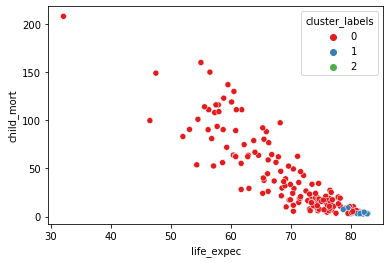

In [49]:
# Here we will be visualizing the clusters formed using hierarichal clustering.
# life_expec
sns.scatterplot(x = 'life_expec', y = 'child_mort', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

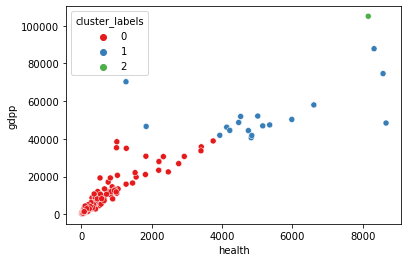

In [50]:
#health
sns.scatterplot(x = 'health', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()


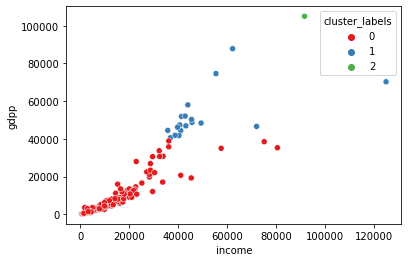

In [51]:
#income
sns.scatterplot(x = 'income', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

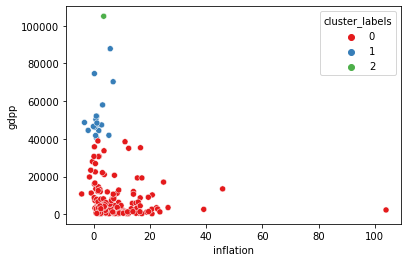

In [52]:
#inflation
sns.scatterplot(x = 'inflation', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

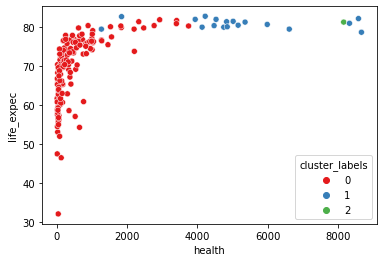

In [53]:
# health vs life_expec
sns.scatterplot(x = 'health', y = 'life_expec', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

### Cluster Profiling

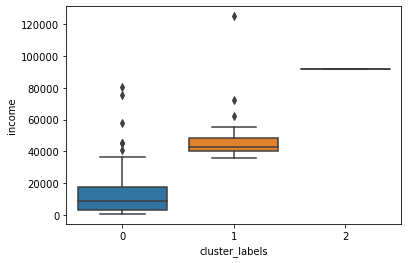

In [54]:
# profiling the clusters with the given variables mentioned in the problem statement
# income
sns.boxplot(data=df_hm,x = 'cluster_labels',y='income')
plt.show()

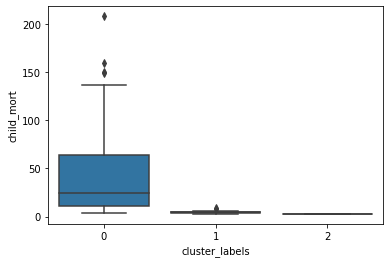

In [55]:
#child_mort
sns.boxplot(data=df_hm,x = 'cluster_labels',y='child_mort')
plt.show()

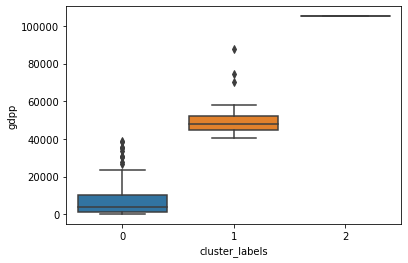

In [56]:
#gdpp
sns.boxplot(data=df_hm,x = 'cluster_labels',y='gdpp')
plt.show()

- Here we can cluster_id 0 is having very lowe gdpp and income with a very high child_mort rate so this will be our focus of help.

### Finding the observations that belong to cluster 0

In [57]:
df_hm[df_hm['cluster_labels']==0]['country']

0              Afghanistan
1                  Albania
2                  Algeria
3                   Angola
4      Antigua and Barbuda
              ...         
162                Vanuatu
163              Venezuela
164                Vietnam
165                  Yemen
166                 Zambia
Name: country, Length: 148, dtype: object

In [58]:
top_h = df_hm[df_hm['cluster_labels']==0].sort_values(by=["child_mort","gdpp","income"], ascending=[False, True,True]) 
top_h = top_h.reset_index().drop('index',1)
top_h.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,0
1,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,0
2,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,0
3,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,0
4,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,0
5,Nigeria,130.0,589.490,118.1310,405.420,5150,104.00,60.5,5.84,2330,0
6,Niger,123.0,77.256,17.9568,170.868,814,2.55,58.8,7.49,348,0
7,Angola,119.0,2199.190,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
8,"Congo, Dem. Rep.",116.0,137.274,26.4194,165.664,609,20.80,57.5,6.54,334,0
9,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.81,57.9,5.87,575,0


In [59]:
#Obtaining top 10 countries which are in dire need of help.
top_10 = top_h.iloc[:10]
top_10['country'].reset_index().drop('index',axis=1)

,country
0,Haiti
1,Sierra Leone
2,Chad
3,Central African Republic
4,Mali
5,Nigeria
6,Niger
7,Angola
8,"Congo, Dem. Rep."
9,Burkina Faso


- Top 10 Countries obtained from Hierarchical clustering.